## Loading of the necessary modules

In [17]:
# [Modules]
# General Python
import sys
import os
from math import sqrt
import random

# Data structures
import numpy as np  # For creating, manipulating arrays, and array calculations
import pandas as pd # For easy accessible tabular data frames, which can exported to Excel

# Image Processing
from scipy import ndimage as ndi # Imaging

# Regression
from lmfit import minimize, Parameters, report_fit
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from skimage import data, color
from skimage.external import tifffile as tff

# Basic image display and plotting tools and notebook settings
import matplotlib as mpl             # Basic plotting module
from matplotlib import pyplot as plt # Basic plotting tools
# Set matplotlib in notebook mode and screen resolutions
%matplotlib inline
# mpl.rcParams['figure.dpi'] = 100     # Set display resolution
# #mpl.rcParams['savefig.dpi'] = 150    # Set figure save resolution
# import seaborn as sns                # Uses mpl, but makes nicer plots
# sns.set(style="whitegrid")           # Set sns style

# For fancy interactive Plotly graphs
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tools
from plotly.tools import FigureFactory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot # For plotly offline mode
# Set plotly to notebook mode
init_notebook_mode(connected=True)
py.sign_in('bjornharink_stanford', 'VqISgcHFwPkY0z50PG47')
#py.sign_in('login_name', 'df8aSdf07asd8faAsd78')  # Plot.ly login and API key, if you have one.

# Bead analysis module
#import bead_analysis as ba
import mrbles

## The main script

### Main config

In [2]:
# Channel settings
DECODE_CHANNELS = slice('l-435','l-780')  # Channel range for decoding
OBJECT_CHANNEL = 'Brightfield'  # Channel for bead finding

# Filtering settings
reference_std_factor_low = 2   # Reference filter xSD from mean low
reference_std_factor_high = 2  # Reference filter xSD from mean high
back_std_factor = 2            # Background filter xSD from mean
set_prob = 2.3                   # Filter based on log probability

### Setting up and loading the reference images
Reference image locations and labels:

In [4]:
# Channel settings
DECODE_CHANNELS = slice('l-435','l-780')  # Channel range for decoding
OBJECT_CHANNEL = 'Brightfield'  # Channel for bead finding

# Reference files
REF_FOLDER = {
    "Dy": r"C:\DATA\20170406 - Reference files - KARA",
    "Sm": r"C:\DATA\20170406 - Reference files - KARA",
    "Tm": r"C:\DATA\20170406 - Reference files - KARA",
    "Eu": r"C:\DATA\20170406 - Reference files - KARA",
    "bkg": r"C:\DATA\20170406 - Reference files - KARA"
}
REF_FILES = {"Dy" : "Dy_Solos_3_MMStack_Pos0.ome.tif",
             "Sm" : "Sm_solos_5_MMStack_Pos0.ome.tif",
             "Tm" : "Tm_solos_3_MMStack_Pos0.ome.tif",
             "Eu" : "Eu_solos_6_MMStack_Pos0.ome.tif",
             "bkg" : "20170320_blank_1_MMStack_Pos0.ome.tif"
}

In [5]:
spec_object = mrbles.References(REF_FOLDER, REF_FILES, OBJECT_CHANNEL, DECODE_CHANNELS)
spec_object.crop_x = slice(312, 712)
spec_object.crop_y = slice(312, 712)

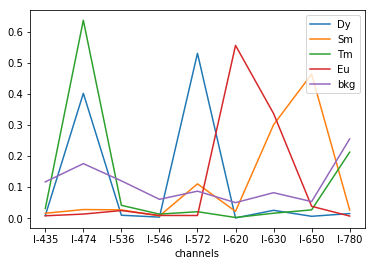

In [6]:
spec_object.load()
spec_object.plot()

Process reference images and add Background Spectrum

### Setting up bead library files

In [63]:
# Target file location
TARGET_FOLDER = r"Z:\General\CodeSets"
TARGET_FILE = os.path.join(TARGET_FOLDER, "20160226_DySmTm_48Codes.csv")
target_load = np.genfromtxt(TARGET_FILE, delimiter=',')
#target = target_load[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,21,27,28,29,30,31,32,33,34,38,10,41,42,43,44,45,46], 1:4]  # Target set to Dy, Sm, Tm (no CeTb) Order: [CeTb, Dy, Sm, Tm]
target = target_load[:, 1:4]  # Target set to Dy, Sm, Tm (no CeTb) Order: [CeTb, Dy, Sm, Tm]

In [64]:
target

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.08449],
       [ 0.     ,  0.     ,  0.2896 ],
       [ 0.     ,  0.     ,  0.78752],
       [ 0.     ,  0.10822,  0.     ],
       [ 0.     ,  0.10822,  0.08449],
       [ 0.     ,  0.10822,  0.2896 ],
       [ 0.     ,  0.10822,  0.78752],
       [ 0.     ,  0.2505 ,  0.     ],
       [ 0.     ,  0.2505 ,  0.08449],
       [ 0.     ,  0.2505 ,  0.2896 ],
       [ 0.     ,  0.43758,  0.     ],
       [ 0.     ,  0.43758,  0.08449],
       [ 0.     ,  0.43758,  0.2896 ],
       [ 0.     ,  0.68356,  0.     ],
       [ 0.     ,  0.68356,  0.08449],
       [ 0.     ,  0.68356,  0.2896 ],
       [ 0.08155,  0.     ,  0.     ],
       [ 0.08155,  0.     ,  0.19141],
       [ 0.08155,  0.     ,  0.65606],
       [ 0.08155,  0.10822,  0.     ],
       [ 0.08155,  0.10822,  0.19141],
       [ 0.08155,  0.10822,  0.65606],
       [ 0.08155,  0.2505 ,  0.     ],
       [ 0.08155,  0.2505 ,  0.19141],
       [ 0.08155,  0.2505

### Set up bead finding, icp, and gmix objects
Except for BEAD_SIZE, these can all stay the default values. They are just expclicity displayed for reference. Technically they can be called like:
- `icp = ba.ICP()`
- `gmix = ba.Classify(target)`

In [65]:
bead_objects = mrbles.FindBeadsImaging(bead_size=18, border_clear=True, circle_size=350)
bead_objects.eccen_param = 0.65
#bead_objects.thr_block = 15
#bead_objects.thr_c = 11
#bead_objects.mask_bkg_buffer = 2
#bead_objects.mask_bkg_size = 11

# ICP settings
icp = mrbles.ICP(matrix_method='std', max_iter=100, tol=1e-4, outlier_pct=0.01, train=False)

# GMM settings
gmix = mrbles.Classify(target, tol=1e-5, min_covar=1e-7, sigma=1e-5, train=False)

### Setting up bead images

In [66]:
# Channel(s) settings
ASSAY_CHANNELS = ['Cy5']  # Must be list!

# slice(Y1, Y2) and slice(X1, X2) Y and X are reversed in array since rows (Y) go first and columns go second (X)
# General Region or interest
CROPx = slice(24, 1000)
CROPy = slice(24, 1000)

# Corresponding Flat-Field image
FF_FOLDER = r"Z:\Data\Setup 1\[Flat-Field and Dark-Field Setup 1]"
FF_FILE = os.path.join(FF_FOLDER, "20170815-FF-Cy5-500ms-169im-MED-BIN2-TopDown.tif")
flat_field = tff.TiffFile(FF_FILE).asarray()
flat_field = flat_field/flat_field.max()  # Normalize Flat-Field

# Setting bead image folder and image patterns. This will select all images following the pattern.
NORM_IMAGE_FOLDER = r"Z:\Data\Setup 1\Huy"
NORM_IMAGE_PATTERN = {"Biotin" : r"20180111_CN_Final_Normal_biotinb_([1-9]|[1-9][0-9])_MMStack_Pos0.ome.tif"}
NORM_CHANNEL = 'Cy5-E 10%'

# Search for files matching the patter in the bead image folder
#bead_image_files = ba.ImageSetRead.scan_path(BEAD_IMAGE_FOLDER, BEAD_IMAGE_PATTERNS['aHis-PVIVIT-Flank'])
#bead_image_files = ba.ImageSetRead.scan_path(NORM_IMAGE_FOLDER, NORM_IMAGE_PATTERN['biotin'])
# Load images. This may take some time.
#bead_image_obj = ba.ImageSetRead(bead_image_files)
#print(bead_image_obj.c_names) # Print channel names

# Image shift correction for assay channel(s)
shift_x = 0
shift_y = 0
CROPx_shift = slice(CROPx.start+shift_x, CROPx.stop+shift_x)
CROPy_shift = slice(CROPy.start+shift_y, CROPy.stop+shift_y)

In [15]:
#bead_image_files

In [67]:
def bead_data_function(image_folder, image_patterns, assay_channels, norm_data=None, norm_channel=None):
    bead_sets_per_bead = {}
    bead_sets_per_code = {}
    bead_images_channels = {}
    bead_set_data_per_bead = {}
    bead_set_data_per_code = {}
    labels_all_bead = {}
    labels_all_inside = {}
    labels_all_annulus = {}
    labels_all_bkg = {}
    for pattern_key, pattern in image_patterns.items():
        print("Analyzing condition: %s" %(pattern_key))
        # Search for files matching the patter in the bead image folder
        bead_image_files = mrbles.ImageSetRead.scan_path(image_folder, pattern)
        # Load images. This may take some time.
        bead_image_obj = mrbles.ImageSetRead(bead_image_files)
        # Load decode channsls
        bead_images_decode = bead_image_obj[:,DECODE_CHANNELS, CROPy, CROPx]
        # Load object channel
        bead_images_object = bead_image_obj[:,OBJECT_CHANNEL, CROPy_shift, CROPx_shift]
        # Load assay channel(s)
        if type(assay_channels) is not list:
            assay_channels = [assay_channels]
        for channel_idx, channel in enumerate(assay_channels):
            print("Analyzing channel: %s" %(channel))
            # Assign images, crop, and FF-correct
            assay_images = bead_image_obj[:,channel, CROPy_shift, CROPx_shift] / flat_field[CROPy_shift, CROPx_shift]
            
            # Setup Pandas DataFrame
            bead_set = \
                pd.DataFrame(columns=['img', 'lbl',                           # Image and label number of bead
                                      'dim_x', 'dim_y', 'dim_r', 'dim_area',  # Bead dimensions
                                      'bkg', 'ref',                           # Background and Reference data
                                      'rat_dy', 'rat_sm', 'rat_tm',           # Ratio data
                                       channel])                              # Assay data
            
            # Find beads and create masks
            labels_bead = []
            labels_inside = []
            labels_annulus = []
            labels_bkg = []
            skipped = []
            kept = list(range(len(bead_images_object)))
            bead_no = 0
            for idx in range(len(bead_images_object)):
                bead_objects.find(bead_images_object[idx])
                if bead_objects.bead_num < 1:
                    skipped.append(idx)
                    kept.remove(idx)
                    print("Removed image %i" % (idx+1))
                    continue
                print("Found %i beads in image %i" %(bead_objects.bead_num, idx+1))
                #labels_inside.append(bead_objects.mask_inside)
                labels_inside.append(bead_objects.mask('mask_inside'))
                labels_bead.append(bead_objects.mask('mask_full'))
                labels_annulus.append(bead_objects.mask('mask_ring'))
                labels_bkg.append(bead_objects.mask('mask_bkg'))
                circles_dim = bead_objects.bead_dims.as_matrix()
                for lbl_idx, lbl in enumerate(bead_objects.bead_labels):
                    bead_set.loc[bead_no,('img', 'lbl', 
                                          'dim_x', 'dim_y', 'dim_r', 'dim_area')] = [idx, lbl, 
                         circles_dim[lbl_idx, 1], circles_dim[lbl_idx, 2], circles_dim[lbl_idx, 3], circles_dim[lbl_idx, 4]]
                    bead_no += 1
                    
#                 image_cc = color.gray2rgb(bead_objects._masked_img)
#                 dims = np.array(np.round(bead_objects.bead_dims_bead.loc[:,('y_centroid','x_centroid','radius')].values), dtype=np.int)
#                 for center_y, center_x, radius in zip(dims[:,0], dims[:,1], dims[:,2]):
#                     line_y = slice(center_y-radius, center_y+radius)
#                     line_x = slice(center_x-radius, center_x+radius)
#                     image_cc[center_y, line_x] = (20, 20, 220)
#                     image_cc[line_y, center_x] = (20, 20, 220)
#                 plt.figure(dpi=100)
#                 plt.imshow(image_cc, cmap=plt.cm.gray)
                
            print("Total number of beads found: %s" % bead_no)
            
            # Save labeled masks
            labels_all_bead[channel] = labels_bead
            labels_all_inside[channel] = labels_inside
            labels_all_annulus[channel] = labels_annulus
            labels_all_bkg[channel] = labels_bkg

            # Delete skipped images
            bead_images_object = np.delete(bead_images_object, skipped, axis=0)
            bead_images_decode = np.delete(bead_images_decode, skipped, axis=0)
            assay_images = np.delete(assay_images, skipped, axis=0)
            
            # Spectral unmix object
            spec_unmix = mrbles.SpectralUnmixing(spec_object)

            # Set bead number to 0
            bead_no = 0
            for lbls_idx, lbls in enumerate(labels_inside):
                # Get bead labels
                idx = bead_objects.get_unique_values(lbls)

                # Spectrally unmix
                spec_unmix.unmix(bead_images_decode[lbls_idx])

                # Set background and reference images
                background = spec_unmix['bkg']  # Device background
                reference = spec_unmix['Eu']    # Internal reference: Eu

                # Make ratio images
                ratio_Dy = spec_unmix['Dy'] / reference
                ratio_Sm = spec_unmix['Sm'] / reference
                ratio_Tm = spec_unmix['Tm'] / reference

                # Get ratios from images
                ratio_data = np.empty((len(idx), target[0].size))
                ratio_data[:, 0] = ndi.labeled_comprehension(ratio_Dy, lbls, idx, np.median, float, -1)
                ratio_data[:, 1] = ndi.labeled_comprehension(ratio_Sm, lbls, idx, np.median, float, -1)
                ratio_data[:, 2] = ndi.labeled_comprehension(ratio_Tm, lbls, idx, np.median, float, -1)

                # Get background and reference data from ratio images
                background_data = ndi.labeled_comprehension(background, lbls, idx, np.median, float, -1)
                reference_data = ndi.labeled_comprehension(reference, lbls, idx, np.median, float, -1)

                # Get assay channel data
                assay_data = ndi.labeled_comprehension(assay_images[lbls_idx], labels_annulus[lbls_idx], idx, np.median, float, -1)

                # Subtract background global per image
                #assay_back_glob = ndi.labeled_comprehension(assay_images[lbls_idx], labels_bead[lbls_idx], 0, np.median, float, -1)
                #assay_data_glob = assay_data - assay_back_glob   # Subtract global background value
                #assay_data_glob[assay_data_glob < 0] = 0     # Set threshold to 0
                #assay_data_final = assay_data_glob    

                # Subtract background local per bead
                assay_back_local = ndi.labeled_comprehension(assay_images[lbls_idx], labels_bkg[lbls_idx], idx, np.median, float, -1)
                assay_data_local = assay_data - assay_back_local  # Subtract global background value
                #assay_data_local[assay_data_local < 0] = 0    # Set threshold to 0
                assay_data_final = assay_data_local

                for lbl in range(bead_objects.get_unique_count(lbls)):
                    bead_set.loc[bead_no,('rat_dy', 'rat_sm', 'rat_tm', 
                                          'bkg', 'ref', 
                                           channel)] = [ratio_data[lbl,0], ratio_data[lbl,1], ratio_data[lbl,2], 
                                                      background_data[lbl], reference_data[lbl], 
                                                      assay_data_final[lbl]]
                    bead_no += 1
                    
            # Filtering
            mask_bkg    = ( (bead_set.bkg > (bead_set.bkg.mean() - back_std_factor * bead_set.bkg.std())) &\
                            (bead_set.bkg < (bead_set.bkg.mean() + back_std_factor * bead_set.bkg.std())) )
            mask_ref    = ( (bead_set.ref > (bead_set.ref.mean() - reference_std_factor_low * bead_set.ref.std())) &\
                            (bead_set.ref < (bead_set.ref.mean() + reference_std_factor_high * bead_set.ref.std())) )
            filter_all = (mask_bkg & mask_ref)

            print("Pre filter: %s" % bead_set.index.size)
            print("Post filter: %s" % bead_set[filter_all].index.size)

            # Pre-filter post-filter images
            #for x in range(3):
                #idx = random.choice(range(len(assay_images)))
                #fig = plt.figure(dpi=150)
                #dims_post = bead_set.loc[(bead_set['img'] == kept[idx]), ('dim_x','dim_y','dim_r')].values
                #ax = fig.add_subplot(1,2,1)
                #ax.axis('off')
                #fig.suptitle("Overlay Image Pre-filter image #: %s" % idx)
                #mrbles.FindBeadsImaging.show_cross_overlay(image=bead_images_object[idx], dims=dims_post)
                #mrbles.FindBeadsImaging.show_image_overlay(assay_images[idx], labels_annulus[idx])
                #ax = fig.add_subplot(1,3,2)
                
                #c_dims_post = bead_set.loc[filter_all & (bead_set['img'] == kept[idx]), ('dim_x','dim_y','dim_r')].values
                #ax.imshow(mrbles.FindBeadsImaging.cirle_overlay(assay_images[idx], dims=c_dims_post), 
                #          cmap='Greys_r')
                #ax = fig.add_subplot(1,2,2)
                #ax.axis('off')
                #fig.suptitle("Overlay Image Post-filter image #: %s" % idx)
                #mrbles.FindBeadsImaging.show_cross_overlay(image=bead_images_object[idx], dims=c_dims_post)
                
            # ICP
            icp.fit(bead_set.loc[filter_all, ('rat_dy', 'rat_sm', 'rat_tm')], target)
            bead_set = bead_set.combine_first(icp.transform())
            print("Tranformation matrix: ", icp.matrix)
            print("Offset vector: ", icp.offset)
            
            # GMM
            gmix.decode(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')])
            bead_set = bead_set.combine_first(gmix.output)
            print("Number of unique codes found:", gmix.found)
            print("Missing codes:", gmix.missing)
            s_score = silhouette_score(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')], gmix.output.code)
            print("Silhouette Coefficient:", s_score)
            print("AIC:", gmix._gmix.aic(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')]))
            print("BIC:", gmix._gmix.bic(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')]))
            
            print("Pre-filter:", bead_no)
            print("Pre log-prob filter:", bead_set.loc[(bead_set.code >= 0)].shape[0])
            print("Final beads no.:", bead_set.loc[(bead_set.code >= 0) & (bead_set.log_prob > set_prob)].shape[0])
            print("Total filtered out: %0.2f%%" % ((1-bead_set.loc[(bead_set.code >= 0) & (bead_set.log_prob > set_prob)].shape[0] / bead_set.shape[0])*100))
            print("Filtered/Total: %i/%i" % (bead_set.shape[0] - bead_set.loc[(bead_set.code >= 0) & (bead_set.log_prob > set_prob)].shape[0], bead_set.shape[0])) 
            
            bead_set_data_per_bead[channel] = bead_set
            
            biotin_string = pattern_key.split("-",1)[1]
            print(biotin_string)
            norm_data_sub = norm_data[biotin_string]
            
            #bead_set_data_per_code[channel] = mrbles.simp.get_stats_per_code(bead_set[bead_set.log_prob > set_prob], channel, norm=norm_data_sub[norm_data_sub.log_prob > set_prob], norm_channel=norm_channel, codes=48)
            bead_set_data_per_code[channel] = mrbles.simp.get_stats_per_code(bead_set[bead_set.log_prob > set_prob], channel, norm=norm_data_sub, norm_channel=norm_channel, codes=48)
            bead_images_channels[channel] = assay_images
        bead_sets_per_bead[pattern_key] = pd.concat(bead_set_data_per_bead)
        bead_sets_per_code[pattern_key] = pd.concat(bead_set_data_per_code)
    return pd.concat(bead_sets_per_bead), pd.concat(bead_sets_per_code)

#### Loading bead images, selecting bead images, and flatfield correction

In [17]:
#bead_norm_per_bead

In [68]:
bead_norm_per_bead, bead_norm_per_code = bead_data_function(NORM_IMAGE_FOLDER, NORM_IMAGE_PATTERN, NORM_CHANNEL)

Analyzing condition: Biotin
Analyzing channel: Cy5-E 10%
[[[ 485.          485.          397.13220215]]]
Found 25 beads in image 1
[[[ 485.          485.          365.03424072]]]
Found 137 beads in image 2
[[[ 489.          489.          351.00567627]]]
Found 70 beads in image 3
[[[ 485.         481.         357.0223999]]]
Found 10 beads in image 4
[[[ 485.          479.          363.03442383]]]
Found 15 beads in image 5
[[[ 479.          473.          350.96011353]]]
Found 178 beads in image 6
[[[ 487.          471.          350.96438599]]]
Found 159 beads in image 7
[[[ 489.          479.          365.01501465]]]
Found 228 beads in image 8
[[[ 479.          481.          363.03442383]]]
Found 28 beads in image 9
[[[ 479.          487.          351.00997925]]]
Found 36 beads in image 10
[[[ 485.          501.          355.00985718]]]
Found 390 beads in image 11
[[[ 481.          477.          377.04772949]]]
Found 355 beads in image 12
[[[ 481.          491.          353.00424194]]]
F

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [48]:
fig = mrbles.inspect.cluster3d_check(bead_norm_per_bead, target, gmix, set_prob=set_prob)
py.iplot(fig, filename='TEST/3D-Cluster')  # Online

NameError: name 'bead_norm_per_bead' is not defined

Analyzing condition: NIR-PxI2
Analyzing channel: Cy5


        Use SourceCatalog.to_table() instead. [mrbles.core]


Found 24 beads in image 1
Found 52 beads in image 2
Found 73 beads in image 3
Found 38 beads in image 4
Found 121 beads in image 5
Found 308 beads in image 6
Found 338 beads in image 7
Found 255 beads in image 8
Found 27 beads in image 9
Found 106 beads in image 10
Found 425 beads in image 11
Found 526 beads in image 12
Found 525 beads in image 13
Found 147 beads in image 14
Found 139 beads in image 15
Found 376 beads in image 16
Found 248 beads in image 17
Found 362 beads in image 18
Found 114 beads in image 19
Found 108 beads in image 20
Found 188 beads in image 21
Found 237 beads in image 22
Found 144 beads in image 23
Total number of beads found: 4881
Pre filter: 4881
Post filter: 4540
Delta:  0.349080483565
Delta:  0.0365623123169
Delta:  0.0294425534132
Delta:  0.0178611471589
Delta:  0.0159890980778
Delta:  0.0152422168244
Delta:  0.0308223383317
Delta:  0.0598731741873
Delta:  0.0294307840901
Delta:  0.000149540092077
Delta:  0.0
Converged after: 11
Tranformation matrix:  [[ 0.

G:\My Drive\[Stanford]\DEV\Encoded Beads Project\Bead Analysis\mrbles\core.py:1666: UserWarning:

Training mode: ON



Number of unique codes found: 48
Missing codes: None
Silhouette Coefficient: 0.663250482821
AIC: -53686.9618958
BIC: -50611.4550784
Pre-filter: 4881
Pre log-prob filter: 4540
Final beads no.: 4345
Total filtered out: 10.98%
Filtered/Total: 536/4881
PxI2
Analyzing condition: aHis-PxI2
Analyzing channel: Cy5
Found 23 beads in image 1
Found 54 beads in image 2
Found 30 beads in image 3
Found 73 beads in image 4
Found 212 beads in image 5
Found 202 beads in image 6
Found 12 beads in image 7
Found 79 beads in image 8
Found 349 beads in image 9
Found 465 beads in image 10
Found 112 beads in image 11
Found 63 beads in image 12
Found 77 beads in image 13
Found 165 beads in image 14
Found 153 beads in image 15
Found 642 beads in image 16
Found 150 beads in image 17
Found 80 beads in image 18
Found 116 beads in image 19
Found 199 beads in image 20
Found 208 beads in image 21
Found 78 beads in image 22
Found 76 beads in image 23
Found 155 beads in image 24
Total number of beads found: 3773
Pre fi

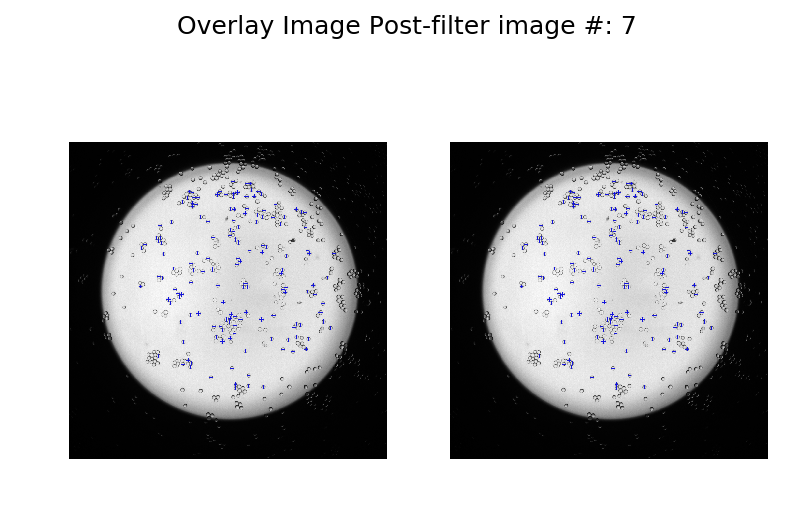

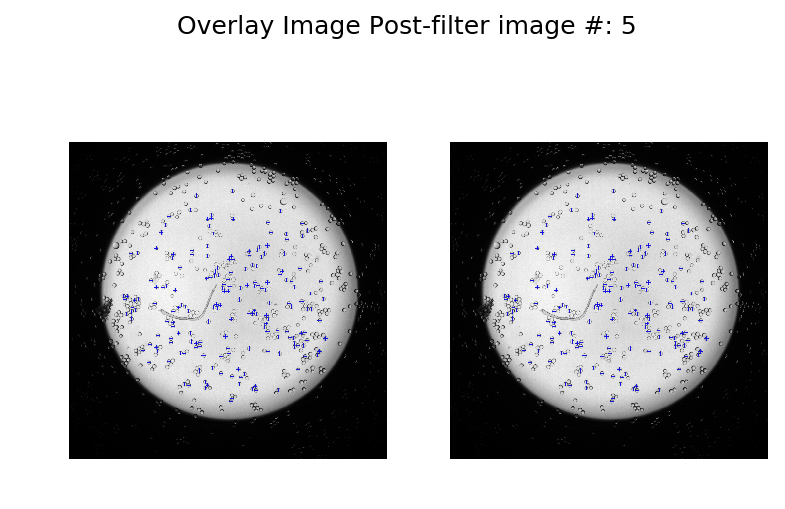

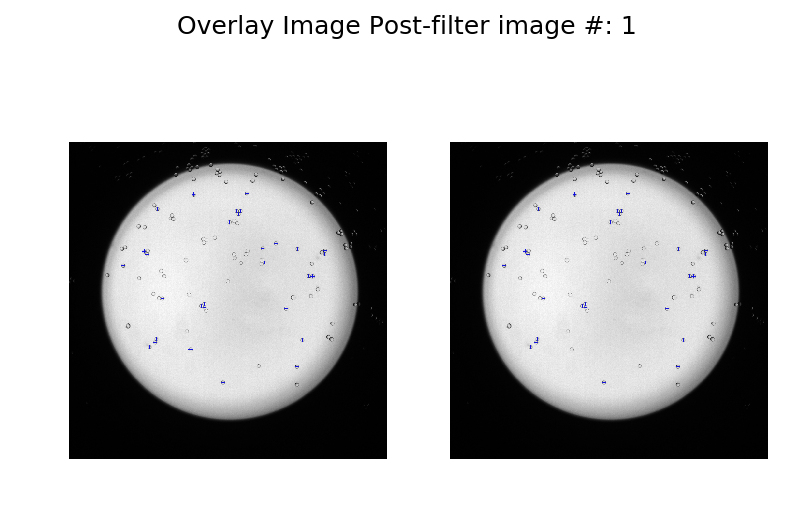

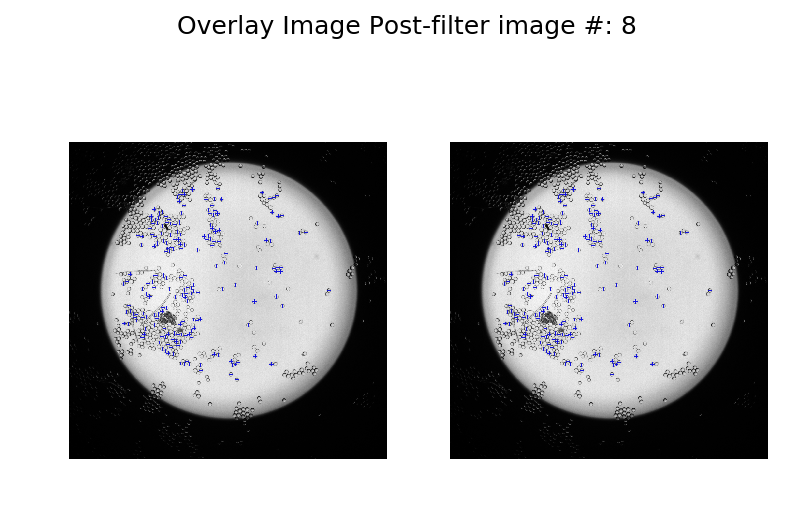

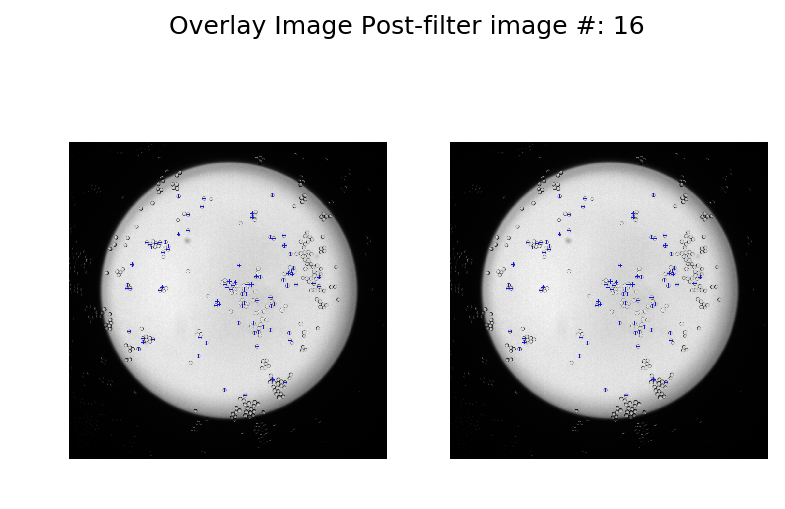

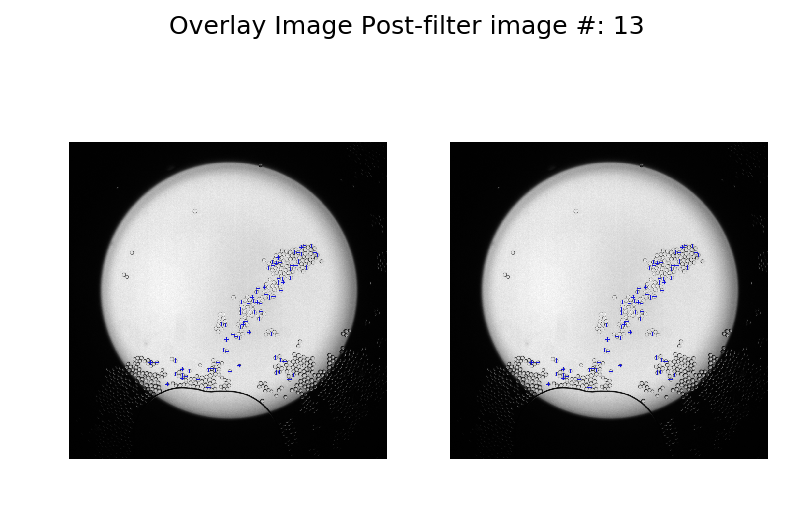

In [20]:
bead_sets_per_bead, bead_sets_per_code = bead_data_function(BEAD_IMAGE_FOLDER, BEAD_IMAGE_PATTERNS, ASSAY_CHANNELS, NORM_IMAGE_PATTERN, NORM_CHANNEL)

### Per code stats

In [14]:
bead_sets_per_code

code         AVG          SD      N         CV        SEM  \
NIR-PxI2  Cy5 0      0  -47.426546  101.403657  133.0  -2.138120   8.792812   
              1      1  -11.883204   96.304789   79.0  -8.104278  10.835135   
              2      2  496.896297  429.998173  136.0   0.865368  36.872039   
              3      3  131.676593  239.270238  109.0   1.817105  22.917932   
              4      4  263.624690  149.794790   80.0   0.568212  16.747567   
              5      5  485.732158  369.564119   79.0   0.760839  41.579212   
              6      6 -163.272622  308.120699  107.0  -1.887155  29.787152   
              7      7 -190.759570  200.284810  123.0  -1.049933  18.059073   
              8      8 -128.646636  226.313424  141.0  -1.759186  19.059029   
              9      9 -209.353564   71.833688  111.0  -0.343121   6.818152   
              10    10 -152.979861   96.952636    4.0  -0.633761  48.476318   
              11    11  -94.740549  255.090710   92.0  -2.692519  26.595045   
              12    12 -158.087130  135.330156   98.0  -0.856048  13.670410   
              13    13 -173.943591  251.223897  100.0  -1.444284  25.122390   
              14    14  399.766974  347.748697  101.0   0.869879  34.602289   
              15    15  571.828807  298.606070   71.0   0.522195  35.438021   
              16    16  812.854367  325.900633   95.0   0.400934  33.436699   
              17    17 -132.810231  258.287068   69.0  -1.944783  31.094109   
              18    18 -191.177988  284.159443  125.0  -1.486361  25.415993   
              19    19 -192.413469  225.544261  107.0  -1.172185  21.804187   
              20    20 -218.428995  209.420494  114.0  -0.958758  19.614026   
              21    21 -230.157032   79.810548   12.0  -0.346766  23.039321   
              22    22 -208.833797  230.869544   91.0  -1.105518  24.201704   
              23    23 -134.096932  578.947273   89.0  -4.317379  61.368288   
              24    24 -184.880371   72.723645  137.0  -0.393355   6.213200   
              25    25 -205.534320   61.452924   47.0  -0.298991   8.963830   
              26    26 -217.584285  234.076391   83.0  -1.075796  25.693222   
              27    27 -105.125237  492.827145   98.0  -4.688000  49.783059   
              28    28 -170.358240  227.737158  104.0  -1.336813  22.331466   
              29    29 -145.163291  237.077130   82.0  -1.633175  26.180789   
...                ...         ...         ...    ...        ...        ...   
aHis-PxI2 Cy5 18    18  -93.834700  461.619625  115.0  -4.919498  43.046252   
              19    19 -182.317214   73.914337   78.0  -0.405416   8.369151   
              20    20 -154.827687  301.467962   97.0  -1.947119  30.609434   
              21    21 -199.252575   64.237230    8.0  -0.322391  22.711290   
              22    22 -171.890114  317.157149   79.0  -1.845116  35.682967   
              23    23 -140.569992  308.255196  117.0  -2.192895  28.498203   
              24    24 -105.473501  458.373025   77.0  -4.345860  52.236454   
              25    25 -166.726429  275.302208   64.0  -1.651221  34.412776   
              26    26 -275.486105  535.310047  102.0  -1.943147  53.003593   
              27    27 -176.297394   83.527874   87.0  -0.473790   8.955128   
              28    28 -174.601830  310.076696   92.0  -1.775907  32.327730   
              29    29 -132.258195  311.058056   43.0  -2.351900  47.435909   
              30    30 -169.763824   82.795689   77.0  -0.487711   9.435444   
              31    31 -157.539948  224.522477   85.0  -1.425178  24.352882   
              32    32 -197.306698  107.955295   74.0  -0.547145  12.549548   
              33    33 -192.920501  224.106526   92.0  -1.161652  23.364720   
              34    34 -141.938039  345.843007   74.0  -2.436577  40.203433   
              35    35 -179.024596   75.295416   51.0  -0.420587  10.543467   
              36    36  -50.326374  399.309990   55.0  -7.934408  53

### Per bead data

In [15]:
bead_sets_per_bead

Cy5          bkg  code  confidence  dim_area  \
NIR-PxI2  Cy5 0     -245.398327  2307.831952   6.0    0.998332     132.0   
              1      -80.412314  1749.326760  42.0    0.948968     102.0   
              2      727.990973  2125.876068  15.0    0.997518     130.0   
              3     -225.685713  1740.309595  19.0    0.999121     120.0   
              4     -261.344452  1070.009159  41.0    0.768551     120.0   
              5      366.449444  2072.416163   3.0    0.999353     113.0   
              6     -206.217230  1796.584609   6.0    0.999344     137.0   
              7     -162.050802   629.086913   9.0    0.996985     123.0   
              8     -157.200003  1405.649144  13.0    0.997411     140.0   
              9     -296.542077  1310.747846  13.0    0.996340     127.0   
              10     -84.599169  2410.420957  46.0    0.983087     121.0   
              11    -252.600912  2746.226335  18.0    0.999076     140.0   
              12    -236.254984  2498.355624  18.0    0.999755     136.0   
              13      59.584042  2764.531966   8.0    0.997710     113.0   
              14     245.881367  3008.841758   4.0    0.998159     152.0   
              15    -102.313620  1425.312240  11.0    0.998438     121.0   
              16    -206.364104  2529.959884  18.0    0.999725     124.0   
              17    -113.772010  3534.674168  18.0    0.985104     119.0   
              18    -156.066063  2549.134842  18.0    0.999548     130.0   
              19    -182.048314  7230.108141   NaN         NaN     130.0   
              20    -258.958395  1899.051523   6.0    0.999183     123.0   
              21     240.520086  3010.186765   3.0    0.998177     121.0   
              22     402.024021  3430.532368   2.0    0.999752     147.0   
              23    1329.411708  1742.258826  16.0    0.995523     138.0   
              24     795.597816  1911.000914  16.0    0.997286     126.0   
              25    -148.387910  2579.397571  12.0    0.997735     104.0   
              26    -246.797067  3714.878382  42.0    0.703972     120.0   
              27    -266.711230  2186.964611  13.0    0.996735     125.0   
              28    -110.462403  1176.822996  40.0    0.983244     113.0   
              29    -137.725870  1571.605118  40.0    0.952493     116.0   
...                         ...          ...   ...         ...       ...   
aHis-PxI2 Cy5 3743  -272.639815  2330.630144  27.0    0.999458     146.0   
              3744  -116.176746  1132.049985  40.0   -3.820218     141.0   
              3745   308.559693  1642.520717  47.0    0.845015     129.0   
              3746  -272.765836  2250.857393  27.0    0.997760     134.0   
              3747  -166.196899  2346.137709  27.0    0.998019      99.0   
              3748  -125.309601   651.275631  41.0    0.898425     102.0   
              3749  -286.647638  2341.425578  27.0    0.998395     136.0   
              3750  -173.327936  1026.940922  41.0    0.989780     140.0   
              3751  -183.006196  2373.113934  27.0    0.999487     124.0   
              3752  -165.286902   906.403181  41.0    0.787669      99.0   
              3753   -45.719909  2904.363193   0.0    0.999854     151.0   
              3754   -84.095192   811.852227  40.0    0.977224     142.0   
              3755  -222.309867  1795.830021  22.0    0.999418     147.0   
              3756  -123.221261  1828.451757  33.0    0.999165     120.0   
              3757  -284.424469  2031.796266  33.0    0.999618     134.0   
              3758  -209.132997  1173.987815  31.0    0.803992     140.0   
              3759  -218.734836  2293.455273  20.0    0.999689     122.0   
              3760  -110.726130  5144.952712  27.0    0.966024     125.0   
              3761   -99.562107  2060.833458  27.0    0.999410     119.0   
              3762  -193.402092  1219.532343  19.0    0.998768     141.0   
              3763  -223.393253  1538.534429  19.0    0.999282     138.0   


### Data export

In [16]:
#folder_prefix = r"Z:\Data\Setup 1\Huy\20170731 PKIVIT\20170814 - Folder 20170731 PKIVIT - Pos1to6 - "
#folder_prefix = r"G:\Team Drives\Calcineurin\CalcineurinBinding\Pyhton Data Analysis\20171105 - NIR aHis\20171105 NIR - "
folder_prefix = r"G:\Team Drives\Calcineurin\CalcineurinBinding\Pyhton Data Analysis\20171105 - NIR aHis\20171109 PxI2 aHis-NIR - "

# Export to Excel.
# bead_sets_per_bead.to_excel(r"%sper bead - NOT NORM.xlsx"%folder_prefix)
# bead_sets_per_code.to_excel(r"%sper code - NORM.xlsx"%folder_prefix)
# bead_norm_per_bead.to_excel(r"%sper bead - Biotin.xlsx"%folder_prefix)
# bead_norm_per_code.to_excel(r"%sper code - Biotin.xlsx"%folder_prefix)

# Export to CSV.
bead_sets_per_bead.to_csv(r"%sper bead - NOT NORM.csv"%folder_prefix)
bead_sets_per_code.to_csv(r"%sper code - NORM.csv"%folder_prefix)
#bead_norm_per_bead.to_csv(r"%sper bead - Biotin.csv"%folder_prefix)
#bead_norm_per_code.to_csv(r"%sper code - Biotin.csv"%folder_prefix)

# Export to Python dataframe: Pickle. Best for keeping oroginal data structure.
# bead_sets_per_bead.to_pickle(r"%sper bead - NOT NORM.pickle"%folder_prefix)
# bead_sets_per_code.to_pickle(r"%sper code - NORM.pickle"%folder_prefix)
# bead_norm_per_bead.to_pickle(r"%sper bead - Biotin.pickle"%folder_prefix)
# bead_norm_per_code.to_pickle(r"%sper code - Biotin.pickle"%folder_prefix)

## Graphs

### Histogram bead data

In [45]:
data = bead_sets_per_bead.loc[('2000 nM', 'Cy5')]
x1 = data.loc[(data.log_prob > set_prob)].Cy5

trace_1 = go.Histogram(
    name='2000 nM NFATc Pos1to6',
    x=x1,
    opacity=0.75
)

data = [trace_1]
layout = go.Layout(
    barmode='overlay',
    yaxis=dict(
        title="Fluorescence Intensity [A.U.]"
        )
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='TEST/Histogram')

### Bar-Plot - Separated Codes

In [50]:
seq_names = []
seq_N = []
for seq_idx, seq_name in enumerate(sequences.sequence):
    seq_names.append("%i - %s" %(seq_idx+1, seq_name))

conc_name = '63 nM'
data_1 = bead_sets_per_code.loc[(conc_name, 'Cy5')]
N_1 = data_1.N.sum()
x1 = data_1.loc[(data_1.code >= 0)]

trace_1_bar = go.Bar(
    x=seq_names,
    y=x1.AVG_NORM,
    name="%s N=[%i]" %(conc_name, N_1),
    text=x1.N,
    error_y=dict(
        type='data',
        array=x1.SEM_NORM,
        visible=True
    )
)

conc_name = '2000 nM'
data_2 = bead_sets_per_code.loc[(conc_name, 'Cy5')]
N_2 = data_2.N.sum()
x2 = data_2.loc[(data_1.code >= 0)]

trace_2_bar = go.Bar(
    x=seq_names,
    y=x2.AVG_NORM,
    name="%s N=[%i]" %(conc_name, N_2),
    text=x2.N,
    error_y=dict(
        type='data',
        array=x2.SEM_NORM,
        visible=True
    )
)

data = [trace_1_bar, trace_2_bar]

layout = go.Layout( 
    yaxis=dict(
        title="Fluorescence Intensity [A.U.]"
        ),
    margin=go.Margin(
        b=140
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.2
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='CN/NFATc/Bar-Plot-Separate')

In [49]:
concs = [63,125,250,500,1000,2000]
line_data = []
for seq_idx, seq in enumerate(sequences.sequence):
    conc_data = []
    conc_data_se = []
    for conc_label in concs:
        data = bead_sets_per_code[bead_sets_per_code.code==seq_idx].loc[('%s nM'%conc_label)]
        conc_data.append(data.MED_NORM) # MED_NORM for normalized Median, AVG_NORM for normalized Mean
        conc_data_se.append(data.SEM_NORM) # SEM_NORM for normalized SEM, SD_NORM for normalized SD
    line_data.append(
        go.Scatter(
            x=concs,
            y=conc_data,
            name=seq,
            error_y=dict(
                type='data',
                array=conc_data_se,
                visible=True
            )
        )
    )

layout = go.Layout( 
    title="Calcineurin - NFATc - Position 1-6 Sequences",
    xaxis=dict(
        title="Concentration [nM]"
        ),
    yaxis=dict(
        title="Mean Fluorescence Intensity +/- SD [A.U.]"
        ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    )
)

fig = go.Figure(data=line_data, layout=layout)
py.iplot(fig, filename='CN/NFATc/Scatter-Plot-All')